## Analysis of Arg or Lys-rich IDRs across the human proteome
#### Last updated 2022-08-015

The notebook here identifies lysine (lys) and arginine (arg)-rich IDRs within IDRs in the human proteome.




In [1]:
import pandas as pd 
import numpy as np

import shephard
from shephard.apis import uniprot, fasta
from shephard.interfaces import si_domains, si_tracks
from shephard.tools import domain_tools

In [2]:
### PLOTTING SETTINGS

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)


### Define notebook parameters

In [3]:
# settings used in paper are as follows, but of course these are 
domain_size = 100
percentile_thresh=95

## Read in human data 
First read in human proteome and annotated with the disordered regions

In [4]:
# read in human IDRs and a track with all the aromatic residues annotated

# read in the human proteome from a uniprot-derived FASTA file
filename ='../shprd_data/human_proteome_validated.fasta'
human_prot = uniprot.uniprot_fasta_to_proteome(filename)

print('Reading in data...')

# load IDRs
si_domains.add_domains_from_file(human_prot, '../shprd_data/shprd_domains_idrs_metapredict_v2.tsv') # metapredict2 IDRS




Reading in data...


#### Define what enrichment means
Next we use a sliding window of size `domain_size` over all IDRs to compute what the 'null' distribution of Arg and Lys fractions in a `domain_size` IDR region is expected to be:

In [7]:
print(f'Calculating lys and arg fractions in IDR subregions for a window-size of {domain_size} residues.')


arg_fracts = []
lys_fracts = []


for protein in human_prot:
    for domain in protein.domains:
        if len(domain) > domain_size:
            
            for frag_idx in range(0,1 +(len(domain)-domain_size)):
                arg_fracts.append(domain.sequence[frag_idx:frag_idx+domain_size].count('R')/domain_size)
                lys_fracts.append(domain.sequence[frag_idx:frag_idx+domain_size].count('K')/domain_size)
                
            
        
        
print(f'\nThere are {len(lys_fracts)} fragments to use as our null distribution...')        
        

Calculating lys and arg fractions in IDR subregions for a window-size of 100 residues.

There are 1804511 fragments to use as our null distribution...


### Define fractional cutoff for 'enriched'
The cell below defines an empirical cuttoff based on the percentile in the distribution of null arg and lys enrichment. This is defined by the `percentile_thresh` which is defined at the top of this notebook. Basically this is the value that means if a `domain_size` IDR is above this `arg_thresh` then it has more arginine residues than `percentile_thresh` (default=95) percent of same-sized IDR windows in the human proteome.

In [11]:

percentile_thresh_str=str(percentile_thresh)
arg_thresh = np.percentile(arg_fracts, percentile_thresh)
lys_thresh = np.percentile(lys_fracts, percentile_thresh)


### Define tracks that highlight regions that are enriched
We use tracks here as basically a binary mask to overlay along the sequence for residues that sit in at least one window enriched for Lys or Arg.

In [12]:
print(f'Calculating sub-regions in IDRs with an enrichment of lys and arg above the {percentile_thresh} percentile')
for idx, protein in enumerate(human_prot):
        
    empty_track_arg = np.zeros(len(protein))
    empty_track_lys = np.zeros(len(protein))
    
    for domain in protein.domains:
        if len(domain) > domain_size:
            
            for frag_idx in range(0,1 +(len(domain)-domain_size)):
                if domain.sequence[frag_idx:frag_idx+domain_size].count('R')/domain_size > arg_thresh:
                    
                    s = (frag_idx+domain.start)-1 # index for numpy
                    e = (frag_idx+domain.start+domain_size)-1 # index for numpy
                    empty_track_arg[s:e] = 1
                    
                if domain.sequence[frag_idx:frag_idx+domain_size].count('K')/domain_size > lys_thresh:
                    
                    s = (frag_idx+domain.start)-1 # index for numpy
                    e = (frag_idx+domain.start+domain_size)-1 # index for numpy
                    empty_track_lys[s:e] = 1
                    
    protein.add_track('arg_enriched',values = empty_track_arg, safe=False)
    protein.add_track('lys_enriched',values = empty_track_lys, safe=False)


Calculating sub-regions in IDRs with an enrichment of lys and arg above the 95 percentile


#### Convert tracks into domains
We then convert these tracks into contigous domains using the `domain_tools.build_domains_from_track_values()` function, a function that takes in a proteome, a track name, and a function that converts the track values into a list or array of 0s and 1s and exisizes out domains from the track. Note our tracks are already binary so the binarize function can just return the track...

This will take ~30-40 seconds to run.

In [13]:
# binary function required by build_domains_from_track_values() even though
# the track is already binary...
def binfx(x):
    return x


arg_rich_domains = domain_tools.build_domains_from_track_values(human_prot, 'arg_enriched', binfx, f'arg_enriched_{percentile_thresh_str}', verbose=False)
si_domains.add_domains_from_dictionary(human_prot, arg_rich_domains, verbose=False)

lys_rich_domains = domain_tools.build_domains_from_track_values(human_prot, 'lys_enriched', binfx, f'lys_enriched_{percentile_thresh_str}', verbose=False)
si_domains.add_domains_from_dictionary(human_prot, lys_rich_domains, verbose=False)



#### Write out
Finally, the next set(s) of cells write these domains, protein names and unique IDs to disk.

In [14]:
arg_rich_uids = []
lys_rich_uids = []


for protein in human_prot:
    for domain in protein.domains:
        if domain.domain_type == f'arg_enriched_{percentile_thresh_str}':
            protein.add_attribute('arg_enriched',True,safe=False)
            arg_rich_uids.append(protein.unique_ID)            
        if domain.domain_type == f'lys_enriched_{percentile_thresh_str}':
            protein.add_attribute('lys_enriched',True,safe=False)
            lys_rich_uids.append(protein.unique_ID)

            
arg_rich_uids = list(set(arg_rich_uids))
lys_rich_uids = list(set(lys_rich_uids))

In [15]:
with open(f'arg_rich_uids_{percentile_thresh_str}.txt', 'w') as fh:
    for uid in arg_rich_uids:
        fh.write(f'{uid}\n')
        
with open(f'lys_rich_uids_{percentile_thresh_str}.txt', 'w') as fh:
    for uid in lys_rich_uids:
        fh.write(f'{uid}\n')        

In [16]:
with open(f'arg_rich_protein_names_{percentile_thresh_str}.txt','w') as fh:
    for uid in arg_rich_uids:
        prot = human_prot.protein(uid)    
        fh.write(f'{prot.unique_ID}, {prot.name}, \n')

with open(f'lys_rich_protein_names_{percentile_thresh_str}.txt','w') as fh:
    for uid in lys_rich_uids:
        prot = human_prot.protein(uid)    
        fh.write(f'{prot.unique_ID}, {prot.name}, \n')
        

In [17]:
si_domains.write_domains(human_prot, f'shprd_domains_lys_arg_rich_domains_{percentile_thresh_str}.tsv', domain_types=[f'lys_enriched_{percentile_thresh_str}', f'arg_enriched_{percentile_thresh_str}'])




### Plot a Venn diagram


In [18]:
#Import libraries
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

In [19]:
arg_rich_uids_c = len(arg_rich_uids)
lys_rich_uids_c = len(lys_rich_uids)
intersection = len(set(arg_rich_uids).intersection(set(lys_rich_uids)))


In [20]:
with open(f'arg_and_lys_rich_uids_{percentile_thresh_str}.txt', 'w') as fh:
    for uid in list(set(arg_rich_uids).intersection(set(lys_rich_uids))):
        fh.write(f'{uid}\n')



meta NOT subset; don't know how to subset; dropped


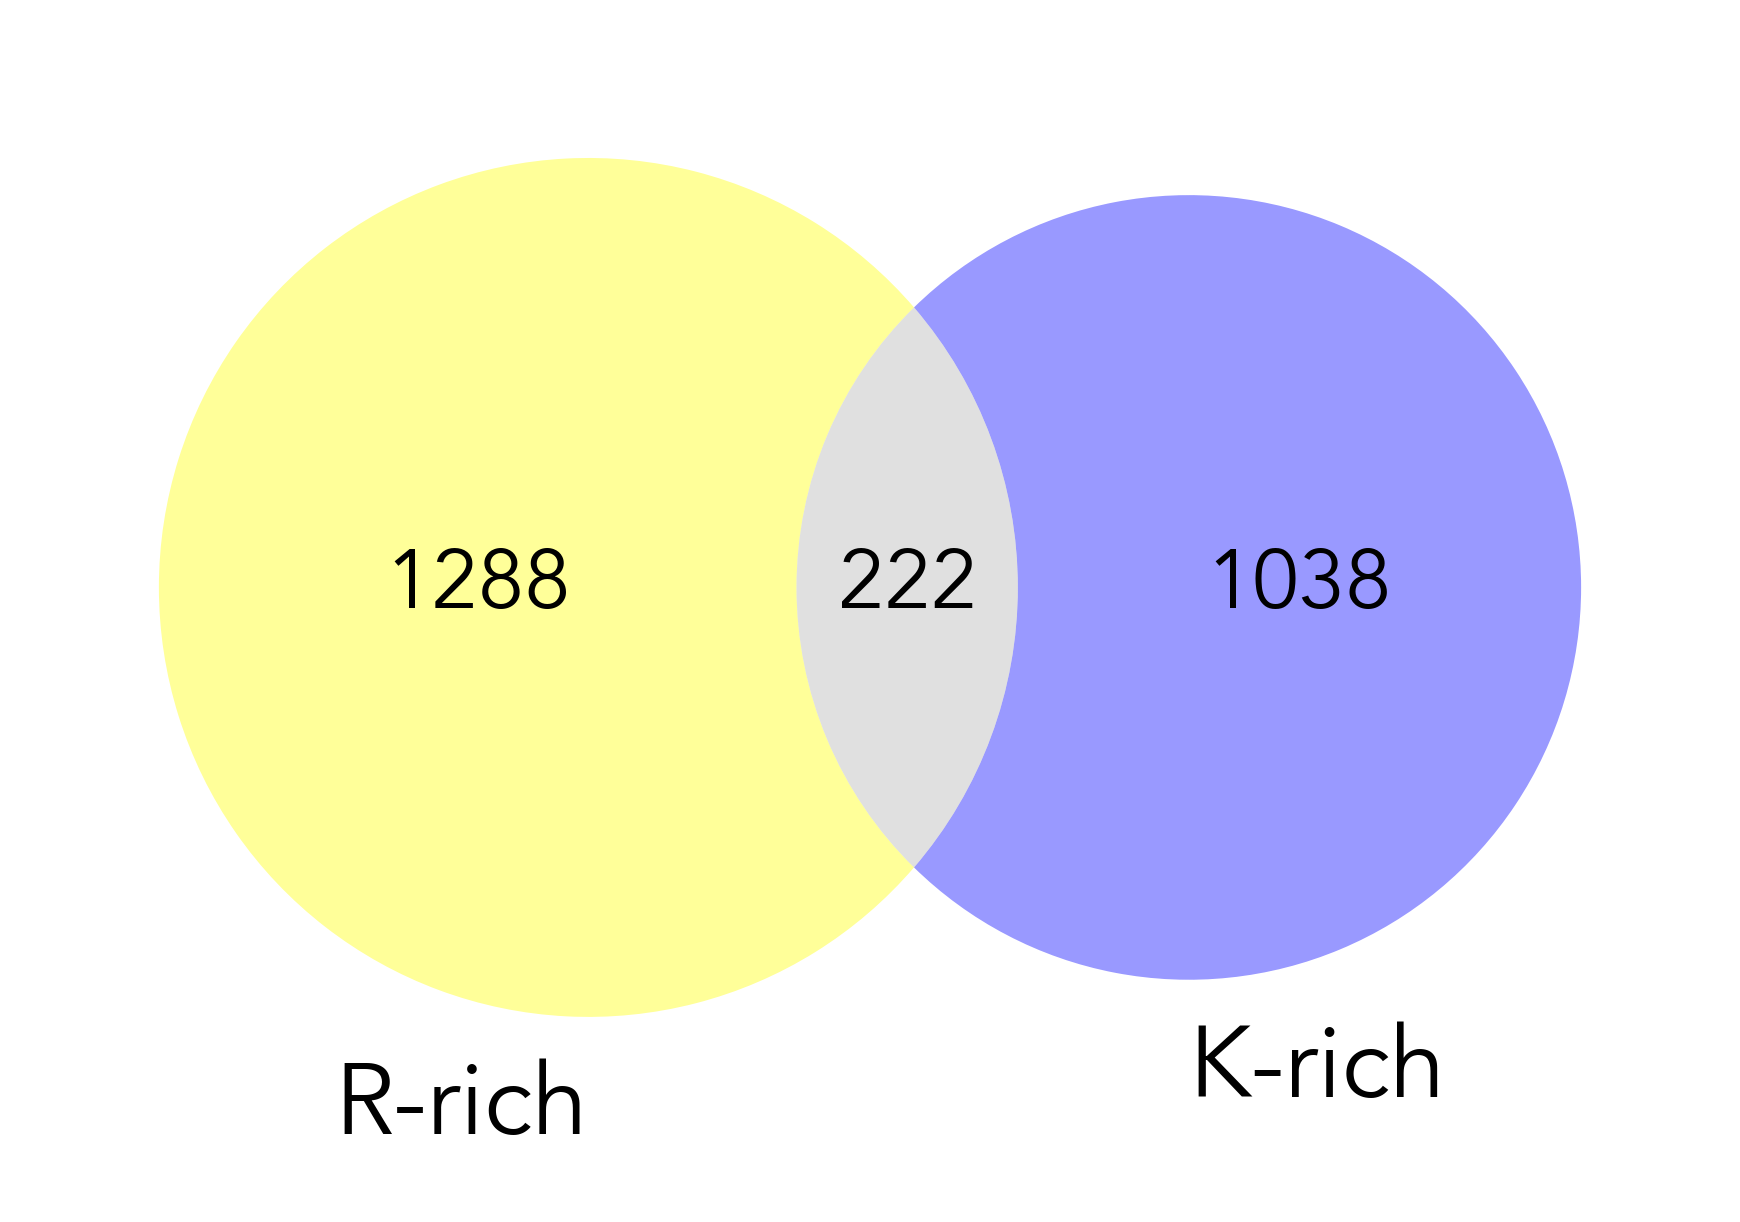

In [21]:
figure(None, (3,3), dpi=300)

venn2(subsets = (arg_rich_uids_c, lys_rich_uids_c,intersection, ), set_labels = ('R-rich', 'K-rich'), set_colors=['yellow','blue'])
plt.tight_layout()
plt.savefig(f'../FIGURES/R_K_venn_{percentile_thresh_str}_percentile.pdf')

